In [1]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:
import matplotlib.pyplot as plt
def draw_plot(title:str, x:list[float], x_label:str, y:list[float], y_label:str):
    "Return the plot of title with the x-axis and the y-axis labeled as x-label and y-axis relatively."
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    return plt

Data loaded from ../data\hubbard/h_2.pkl
[2.006035989684991, 1.7578343894666024]


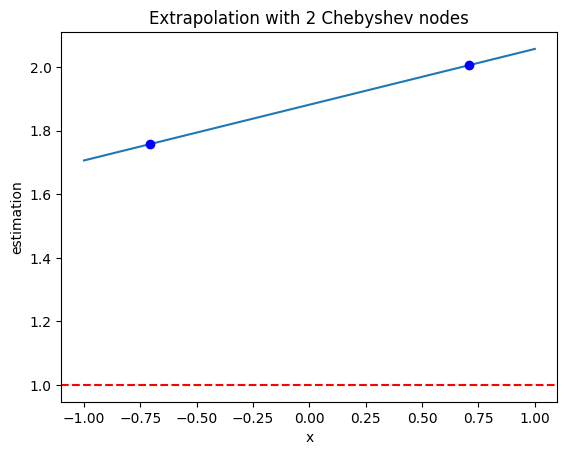

[1.4893102237799307, 1.3934828912356845, 1.4937225074076261, 1.595036106410812]


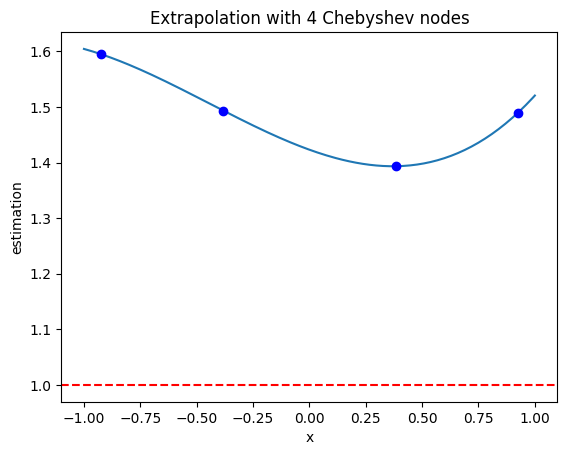

[2.009000264455024, 1.4971360004135117, 1.6264791814234614, 1.6699729090379627, 1.7163122267293545, 1.751740819717483]


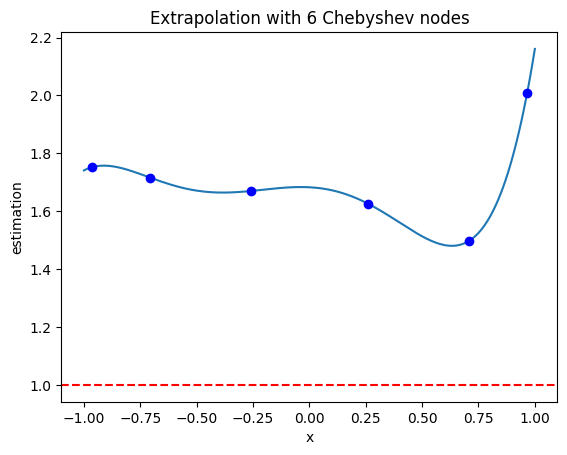

[1.514185578020648, 1.7587733963490142, 1.6717398776299646, 1.501837348279324, 1.5588627856983528, 1.5546789265490593, 1.5490468857842463, 1.5861827396034427]


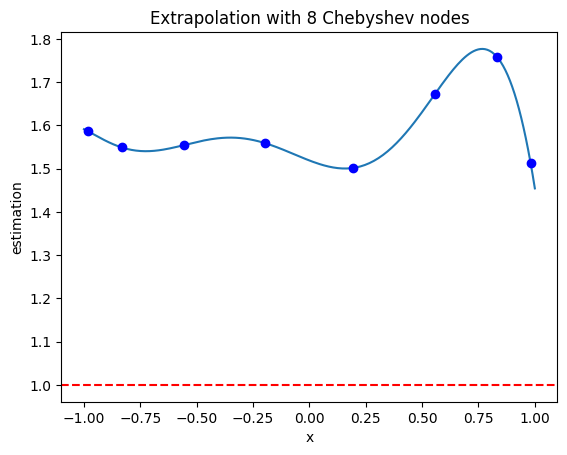

In [18]:
from contextlib import redirect_stdout
from qiskit_aer import Aer
from scripts.algo.iterative_phase_estimation import iterative_phase_estimation_v2
from scripts.algo.chebyshev import chebyshev_nodes, chebyshev_barycentric_interp_point
import scipy
import numpy as np
from qiskit_algorithms import NumPyEigensolver
from scripts.algo.qdrift import qdrift
from scripts.database import DataManager, Hubbard

data = DataManager("../data")  # Create DataManager instance
eigensolver = NumPyEigensolver()
domain = np.linspace(-1, 1, 200)

ld = data.load('hubbard', "h_2") # load the hubbard model
ld.decompose(-1, 2)
decomposition = ld.get_decomp()
obt = decomposition.get_term('obt')
tbt = decomposition.get_term('tbt')
hubbard_matrix = obt.matrix + tbt.matrix
exact_eigenvalue, eigenvectors = scipy.linalg.eig(hubbard_matrix)
expected = min(exact_eigenvalue)
t = 1
num_eval = 10000 # number of iterations of phase estimation
selected_backend = Aer.get_backend('qasm_simulator')
for n in range(2, 10, 2):  # number of the Chebyshev nodes
    data_point = []
    estimations = []
    nodes = chebyshev_nodes(n)
    for node in nodes:
        N = np.ceil(t / np.abs(node))
        h_list, v_list = qdrift(ld, N)
        for h in h_list: # hermitian
            exact_eigenvalue, eigenvectors= scipy.linalg.eig(h)
            # pick eigenstate that corresponds to smallest eigenvalue
            eigenstate = eigenvectors[:, np.argmin(exact_eigenvalue)]
            U = scipy.linalg.expm(-1j * h * t)
            with HiddenPrints():
                p_0, qc = iterative_phase_estimation_v2(U, num_eval, eigenstate, selected_backend, num_qubits=1)
            estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0))
            estimations.append(estimated_eigenvalue)
        data_point.append(np.average(estimations))
    
    print(data_point)
    plt = draw_plot(f'Extrapolation with {len(nodes)} Chebyshev nodes', domain, 'x', [chebyshev_barycentric_interp_point(x, n, data_point) for x in domain], 'estimation')
    plt.plot(nodes, data_point, 'bo')
    plt.axhline(expected, color='r', linestyle='--')
    plt.show()